In [1]:
import json
import torch
import seaborn
import pylab as mpl
import matplotlib.pyplot as plt
from kt_base_model import get_kt_batch, KT, KTData
from ec_geo_model import get_ec_batch, EC, ECData
from kt_ec_mtl_train import Trainer

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

print('torch.__version__: ', torch.__version__)
print('cuda.__version__: ', torch.version.cuda)
print(torch.cuda.is_available())

torch.__version__:  1.7.0+cu110
cuda.__version__:  11.0
True


In [2]:
n_question = 8
n_pid = 1500
seq_len = 30
n_blocks = 1
mid_size = 64
d_model = 128
dropout = 0.05
epoch_num = 25

lr_ec = 0
lr_kt = 2e-4
bs_ec = 0 
bs_kt = 16 
l2_ec = 0
l2_kt = 2e-4
n_ec = 0
n_kt = 1
max_grad_norm = -1

In [3]:
name_dict = {'array': 0, 'hash-table': 1, 'math': 2, 'string': 3,
             'dynamic-programming': 4, 'greedy': 5, 'sorting': 6, 'depth-first-search': 7}

In [4]:
with open('./problem_data_a.json', 'r', encoding='utf8')as fp:
    data = json.load(fp)
with open('glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()
print('exer_num', len(data))

exer_num 1500


In [5]:
trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

In [6]:
glove = ECData(data=data, name_dict=name_dict, trained_dict=trained_dict, 
               train_path='./ec_train_data.json', test_path='./ec_test_data.json')
glove.get_words()
glove.get_id()

In [7]:
data = KTData(n_question=n_question, seq_len=seq_len)
data.load_data('./exercise_data_a.txt', train_path='./kt_train_data.txt', test_path='./kt_test_data.txt')

In [8]:
train_kt = get_kt_batch(data.q_train, data.qa_train, data.p_train, bs_kt)
test_kt = get_kt_batch(data.q_test, data.qa_test, data.p_test, bs_kt)
print('train_kt', len(train_kt), ', test_kt', len(test_kt))
print('test_rate', len(test_kt) / (len(test_kt) + len(train_kt)))

train_kt 179 , test_kt 79
test_rate 0.3062015503875969


In [9]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
tra_kt_loss, tes_kt_loss = list(), list()
tra_kt_acc1, tes_kt_acc1 = list(), list()
tra_kt_acc2, tes_kt_acc2 = list(), list()
tra_kt_acc3, tes_kt_acc3 = list(), list()
tra_kt_acc4, tes_kt_acc4 = list(), list()
tra_ec_loss, tes_ec_loss = list(), list()
tra_ec_acc1, tes_ec_acc1 = list(), list()
tra_ec_acc2, tes_ec_acc2 = list(), list()
tra_ec_acc3, tes_ec_acc3 = list(), list()
tra_ec_hit1, tes_ec_hit1 = list(), list()
tra_ec_hit2, tes_ec_hit2 = list(), list()
tra_ec_hit3, tes_ec_hit3 = list(), list()

In [10]:
ec_net = EC(inp_size=50, mid_size=mid_size, num_words=glove.word_num, num_types=len(name_dict), 
            num_layers=1, weight=torch.tensor(glove.embedding, dtype=torch.float))

d:\pycharmprojects\ecnu-eduktm\venv\lib\site-packages\torch\nn\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [11]:
state = torch.load('./results/ec_geo_model.pth')
ec_net.load_state_dict(state['ec_net'])

<All keys matched successfully>

In [12]:
kt_net = KT(n_question=n_question, n_pid=n_pid, n_blocks=n_blocks, d_model=d_model, dropout=dropout)

In [13]:
trainer = Trainer(ec_net=ec_net, kt_net=kt_net, epoch_num=epoch_num, lr_ec=lr_ec, lr_kt=lr_kt, 
                  bs_ec=bs_ec, bs_kt=bs_kt, l2_ec=l2_ec, l2_kt=l2_kt, max_grad_norm=max_grad_norm, pre='ec')
epoch = 0

In [14]:
for epoch in range(epoch_num):
    loss_tot = trainer.kt_func(train_kt) / len(train_kt) / bs_kt / n_kt

    tr_kt_loss, tr_kt_acc1, tr_kt_acc2, tr_kt_acc3, tr_kt_acc4 = trainer.kt_eval(train_kt)
    te_kt_loss, te_kt_acc1, te_kt_acc2, te_kt_acc3, te_kt_acc4 = trainer.kt_eval(test_kt)

    tra_kt_loss.append(tr_kt_loss / len(train_kt) / bs_kt)
    tes_kt_loss.append(te_kt_loss / len(test_kt) / bs_kt)
    tra_kt_acc1.append(tr_kt_acc1)
    tes_kt_acc1.append(te_kt_acc1)
    tra_kt_acc2.append(tr_kt_acc2)
    tes_kt_acc2.append(te_kt_acc2)
    tra_kt_acc3.append(tr_kt_acc3)
    tes_kt_acc3.append(te_kt_acc3)
    tra_kt_acc4.append(tr_kt_acc4)
    tes_kt_acc4.append(te_kt_acc4)
    print("---------- iteration", epoch + 1, "----------")
    print("total loss:", loss_tot)
    print("kt train loss:", tr_kt_loss / len(train_kt))
    print("kt train acc:", tr_kt_acc2, ", ", "kt test acc:", te_kt_acc2)

D:\PyCharmProjects\ecnu-EduKTM\paper2a\kt_ec_mtl_train.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  acc = torch.mean(torch.tensor(pred == y, dtype=torch.float))


---------- iteration 1 ----------
total loss: tensor([13.3562], device='cuda:0')
kt train loss: 52.4330686111024
kt train acc: 0.23987430167597765 ,  kt test acc: 0.2231012658227848
---------- iteration 2 ----------
total loss: tensor([2.5188], device='cuda:0')
kt train loss: 26.701569077688887
kt train acc: 0.40118715083798884 ,  kt test acc: 0.3662974683544304
---------- iteration 3 ----------
total loss: tensor([1.8191], device='cuda:0')
kt train loss: 23.94688424051807
kt train acc: 0.47067039106145253 ,  kt test acc: 0.435126582278481
---------- iteration 4 ----------
total loss: tensor([1.5635], device='cuda:0')
kt train loss: 18.467500325854264
kt train acc: 0.5104748603351955 ,  kt test acc: 0.46914556962025317
---------- iteration 5 ----------
total loss: tensor([1.3736], device='cuda:0')
kt train loss: 16.38188775291656
kt train acc: 0.5069832402234636 ,  kt test acc: 0.48813291139240506
---------- iteration 6 ----------
total loss: tensor([1.2677], device='cuda:0')
kt train 

In [15]:
epoch += 1 

trainer.model_save(epoch, n_ec=0, n_kt=1, path='./results/kt_pre_model.pth')

In [16]:
trainer.kt_valid('./exercise_data_b.txt', './results/kt_pre_valid.txt')

In [17]:
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1])
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1])
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1])
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1])

train_kt_acc_single: 0.9901648590018629 , train_kt_acc_every: 0.7800279329608939
train_kt_acc_right: 0.9904128356352865 , train_kt_acc_wrong: 0.980104830344962
test_kt_acc_single: 0.9844162969649592 , test_kt_acc_every: 0.6795886075949367
test_kt_acc_right: 0.9853757868839216 , test_kt_acc_wrong: 0.9701401636570315


In [18]:
file = open("./results/kt_pre_desc.txt",'w') 
print('train_kt_acc_single:', tra_kt_acc1[-1], ', train_kt_acc_every:', tra_kt_acc2[-1], file=file)
print('train_kt_acc_right:', tra_kt_acc3[-1], ', train_kt_acc_wrong:', tra_kt_acc4[-1], file=file)
print('test_kt_acc_single:', tes_kt_acc1[-1], ', test_kt_acc_every:', tes_kt_acc2[-1], file=file)
print('test_kt_acc_right:', tes_kt_acc3[-1], ', test_kt_acc_wrong:', tes_kt_acc4[-1], file=file)
print('', file=file)
print('train_kt_acc_single:', tra_kt_acc1, file=file)
print('train_kt_acc_every:', tra_kt_acc2, file=file)
print('train_kt_acc_right:', tra_kt_acc3, file=file)
print('train_kt_acc_wrong:', tra_kt_acc4, file=file)
print('test_kt_acc_single:', tes_kt_acc1, file=file)
print('test_kt_acc_every:', tes_kt_acc2, file=file)
print('test_kt_acc_right:', tes_kt_acc3, file=file)
print('test_kt_acc_wrong:', tes_kt_acc4, file=file)
file.close()

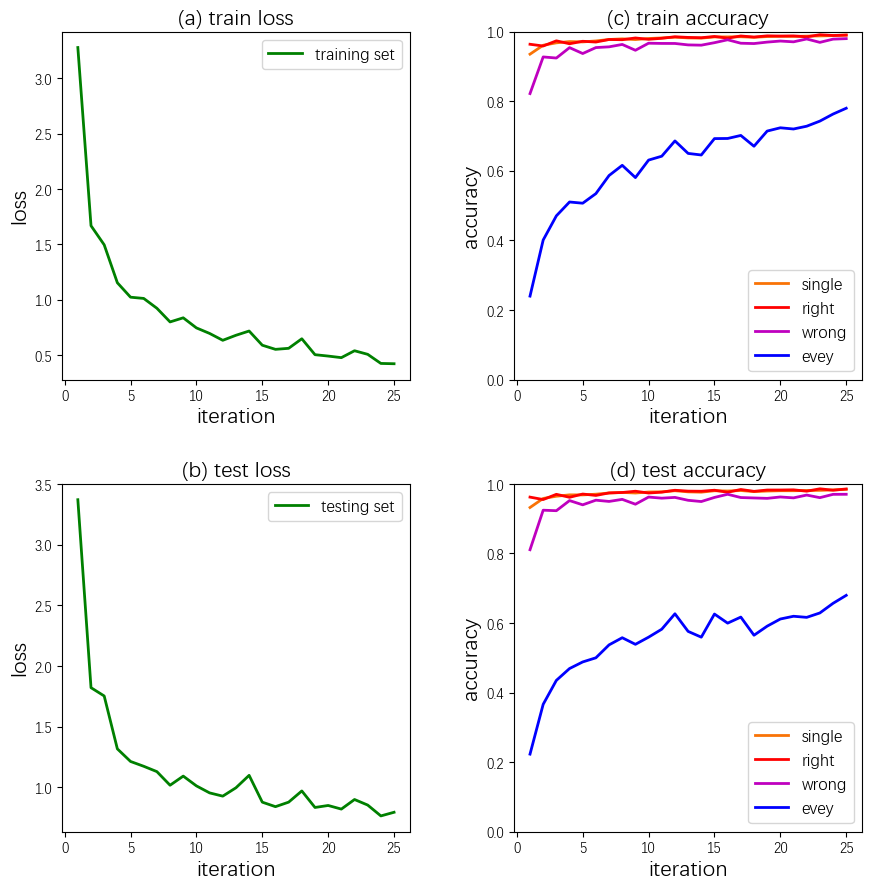

In [19]:
x_range = list(range(1, len(tra_kt_loss) + 1))
fig = plt.figure(num=1, figsize=(10, 10), dpi=100, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 4)

l1, = ax1.plot(x_range, tra_kt_loss, c='g', lw='2')
ax1.set_title('(a) train loss', fontsize=16)
ax1.set_xlabel('iteration', fontsize=16)
ax1.set_ylabel('loss', fontsize=16)
ax1.legend([l1, ], ['training set'], loc='upper right', fontsize=12)  

l1, = ax2.plot(x_range, tes_kt_loss, c='g', lw='2')
ax2.set_title('(b) test loss', fontsize=16)
ax2.set_xlabel('iteration', fontsize=16)
ax2.set_ylabel('loss', fontsize=16)
ax2.legend([l1, ], ['testing set', ], loc='upper right', fontsize=12)  

l1, = ax3.plot(x_range, tra_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax3.plot(x_range, tra_kt_acc3, c='r', lw='2')
l3, = ax3.plot(x_range, tra_kt_acc4, c='m', lw='2')
l4, = ax3.plot(x_range, tra_kt_acc2, c='b', lw='2')
ax3.set_title('(c) train accuracy', fontsize=16)
ax3.set_xlabel('iteration', fontsize=16)
ax3.set_ylabel('accuracy', fontsize=16)
ax3.set_ylim((0, 1))
ax3.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

l1, = ax4.plot(x_range, tes_kt_acc1, c=seaborn.xkcd_rgb['orange'], lw='2')
l2, = ax4.plot(x_range, tes_kt_acc3, c='r', lw='2')
l3, = ax4.plot(x_range, tes_kt_acc4, c='m', lw='2')
l4, = ax4.plot(x_range, tes_kt_acc2, c='b', lw='2')
ax4.set_title('(d) test accuracy', fontsize=16)
ax4.set_xlabel('iteration', fontsize=16)
ax4.set_ylabel('accuracy', fontsize=16)
ax4.set_ylim((0, 1))
ax4.legend([l1, l2, l3, l4], ['single', 'right', 'wrong', 'evey'], loc='lower right', fontsize=12)  

plt.savefig('./results/kt_pre_total.jpg')